# Evaluation of Q-Learning

### Import dependencies

In [1]:
! pip show gym

Name: gym
Version: 0.25.2
Summary: Gym: A universal API for reinforcement learning environments
Home-page: https://www.gymlibrary.ml/
Author: Gym Community
Author-email: jkterry@umd.edu
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: cloudpickle, gym-notices, numpy
Required-by: dopamine_rl


In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
from collections import deque
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

if not hasattr(np, "bool8"):
    np.bool8 = np.bool_


### Load the trained Q-Learning agent's Q-Table

In [3]:
Q = np.load("q_learning_q_table.npy")
bins = np.load("q_learning_bins.npy", allow_pickle=True)

### Define the helper functions(same as the Q-Learning training file)

In [4]:
def create_bins(num_bins, lower_bounds, upper_bounds):
    bins = []
    for i in range(len(num_bins)):
        # Create num_bins[i]-1 cut points between lower and upper bound
        bins.append(np.linspace(lower_bounds[i], upper_bounds[i], num_bins[i] - 1))
    return bins

def discretize_state(state, bins):
    # Map each continuous state value into its corresponding bin index
    return tuple(np.digitize(s, b) for s, b in zip(state, bins))

### Run the evaluation and record the video:

(Warning the block below going to take 3-5 min to execute)

In [5]:
import gym
import numpy as np
from gym.wrappers import RecordVideo

# Ensure that eval_episodes is defined before using it in the lambda function
eval_episodes = 100

# Create a new evaluation environment with video recording enabled.
video_folder = "evaluation_v"
env_evaluation = gym.make("CartPole-v1", render_mode="rgb_array")
env_evaluation = RecordVideo(
    env_evaluation,
    video_folder=video_folder,
    episode_trigger=lambda ep:ep % 10 == 0,
    name_prefix="evaluation"
)

result = env_evaluation.reset()
observation, info = result[:2]


# Assume discretize_state, bins, and Q are defined elsewhere in your notebook
evaluation_rewards_Q_Learning = []
max_steps = 500

for ep in range(1, eval_episodes + 1):
    state = env_evaluation.reset()
    state_disc = discretize_state(state, bins)
    cumulative_reward = 0
    done = False

    for step in range(max_steps):
        # Pure exploitation: select the best action from Q-table (Pure Greedy)
        action = np.argmax(Q[state_disc])
        next_state, reward, done, info = env_evaluation.step(action)
        cumulative_reward += reward
        state_disc = discretize_state(next_state, bins)

        # Explicitly render the frame so it gets recorded
        env_evaluation.render()

        if done:
            break

    evaluation_rewards_Q_Learning.append(cumulative_reward)
    print(f"Evaluation Episode {ep}: Reward = {cumulative_reward}")

env_evaluation.close()

avg_reward = np.mean(evaluation_rewards_Q_Learning)
print(f"Average Reward over {eval_episodes} evaluation episodes: {avg_reward:.2f}")


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Evaluation Episode 1: Reward = 500.0
Evaluation Episode 2: Reward = 500.0
Evaluation Episode 3: Reward = 500.0
Evaluation Episode 4: Reward = 500.0
Evaluation Episode 5: Reward = 500.0
Evaluation Episode 6: Reward = 500.0
Evaluation Episode 7: Reward = 500.0
Evaluation Episode 8: Reward = 500.0
Evaluation Episode 9: Reward = 500.0
Evaluation Episode 10: Reward = 500.0
Evaluation Episode 11: Reward = 500.0
Evaluation Episode 12: Reward = 500.0
Evaluation Episode 13: Reward = 500.0
Evaluation Episode 14: Reward = 500.0
Evaluation Episode 15: Reward = 500.0
Evaluation Episode 16: Reward = 500.0
Evaluation Episode 17: Reward = 500.0
Evaluation Episode 18: Reward = 500.0
Evaluation Episode 19: Reward = 500.0
Evaluation Episode 20: Reward = 500.0
Evaluation Episode 21: Reward = 500.0
Evaluation Episode 22: Reward = 500.0
Evaluation Episode 23: Reward = 500.0
Evaluation Episode 24: Reward = 500.0
Evaluation Episode 25: Reward = 500.0
Evaluation Episode 26: Reward = 500.0
Evaluation Episode 27

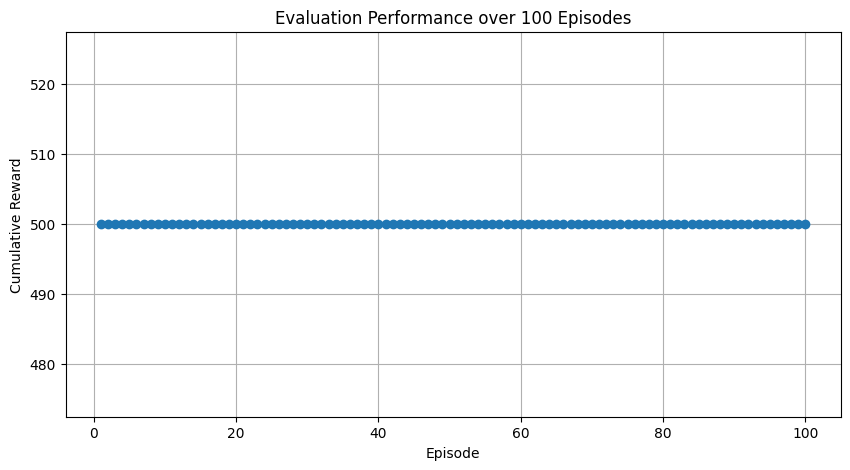

Average Reward over 100 evaluation episodes: 500.00


In [6]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, eval_episodes + 1), evaluation_rewards_Q_Learning, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Evaluation Performance over 100 Episodes")
plt.grid(True)
plt.show()

# Also print the average reward
avg_reward = np.mean(evaluation_rewards_Q_Learning)
print(f"Average Reward over {eval_episodes} evaluation episodes: {avg_reward:.2f}")


### Evaluation of Video

In [7]:
from IPython.display import Video
Video("./evaluation_v/evaluation-episode-90.mp4", embed=True)


# Evaluation of Deep Q-learning

### Import Dependencies

In [8]:
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import gym
from collections import deque
import matplotlib.pyplot as plt

import io
import base64
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
from IPython.display import HTML
from IPython import display as ipythondisplay

if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

### Define the DQN network

In [9]:
# Define DQN network
# DQN network here is a subclass of torch.nn.module
class DQN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()

        # define the first fully connected layer that takes input features
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        # define the second fully connected layer that takes the output of the first layer
        # and maps it to another hidden representation of size 'hidden_dim'
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        # Define the output layer that maps the final hidden representation to the Q-values for each action,
        # where 'output_dim' is the number of possible actions
        self.out = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # self.fc1(x) means passing the data through the first layer called self.fc1
        # apply ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x) # return calculated output

### Define the helper function: step_env

In [10]:
def step_env(env, action):
    result = env.step(action)
    # If 4 values, legacy gym: (next_state, reward, done, info)
    if len(result) == 4:
        next_state, reward, done, info = result
    # If 5 values, new gym API: (next_state, reward, terminated, truncated, info)
    elif len(result) == 5:
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        raise ValueError("Unexpected number of values returned from env.step()")
    return next_state, reward, done, info

### Define the evaluate_dqn_agent function

In [11]:
def evaluate_dqn_agent(env, policy_net, episodes=10, max_steps=500):
    """
    Evaluate the trained DQN agent on the given environment.

    Parameters:
        env: Gym environment for evaluation.
        policy_net: The trained DQN policy network.
        episodes: Number of evaluation episodes.
        max_steps: Maximum steps per episode.

    Returns:
        List of cumulative rewards for each episode.
    """
    # Choose the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net.eval()  # Set the network in evaluation mode.
    rewards = []

    for episode in range(episodes):
        # Reset the environment and handle the new Gym API format.
        result = env.reset(return_info=True)
        state = result[0] if isinstance(result, tuple) else result
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cumulative_reward = 0

        for t in range(max_steps):
            # Use the policy network to select an action.

            env.render()
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.argmax().item()
            next_state, reward, done, info = step_env(env, action)
            cumulative_reward += reward
            # Handle possible tuple in the next state.
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

            if done:
                break

        rewards.append(cumulative_reward)
        print(f"Evaluation Episode {episode+1}: Reward = {cumulative_reward}")

    avg_reward = np.mean(rewards)
    print(f"Average Reward over {episodes} evaluation episodes: {avg_reward:.2f}")
    return rewards


### Initialize the DQN model

In [12]:
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture exactly as used during training.
input_dim = 4     # For CartPole-v1, there are 4 state values.
hidden_dim = 64   # Hidden layer size must be the same as in training.
output_dim = 2    # For CartPole-v1, there are 2 possible actions.

# Initialize the model and load the saved state dictionary.
policy_net = DQN(input_dim, hidden_dim, output_dim).to(device)
# Load the saved state dictionary into the policy network from the 'policy_net.pth' file,
policy_net.load_state_dict(torch.load("policy_net.pth", map_location=device))
policy_net.eval()  # Set the model to evaluation mode




DQN(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

### Run the evaluation and record the video:

In [13]:
# Setup the evaluation environment with video recording enabled.
video_folder = "evaluation_videos"
# Define which episode to record. For example, if episodes=10, record the 10th episode (index 9).
eval_episode_to_record = 100

env = gym.make("CartPole-v1",render_mode="rgb_array")
env = RecordVideo(env,
                  video_folder=video_folder,
                  episode_trigger=lambda ep:ep % 10 == 0,
                  name_prefix="evaluation")


evaluation_rewards_for_DeepQ_Learning = evaluate_dqn_agent(env, policy_net, episodes=100)
env.close()

Evaluation Episode 1: Reward = 500.0
Evaluation Episode 2: Reward = 500.0
Evaluation Episode 3: Reward = 500.0
Evaluation Episode 4: Reward = 500.0
Evaluation Episode 5: Reward = 500.0
Evaluation Episode 6: Reward = 500.0
Evaluation Episode 7: Reward = 500.0
Evaluation Episode 8: Reward = 500.0
Evaluation Episode 9: Reward = 500.0
Evaluation Episode 10: Reward = 500.0
Evaluation Episode 11: Reward = 500.0
Evaluation Episode 12: Reward = 500.0
Evaluation Episode 13: Reward = 500.0
Evaluation Episode 14: Reward = 500.0
Evaluation Episode 15: Reward = 500.0
Evaluation Episode 16: Reward = 500.0
Evaluation Episode 17: Reward = 500.0
Evaluation Episode 18: Reward = 500.0
Evaluation Episode 19: Reward = 500.0
Evaluation Episode 20: Reward = 500.0
Evaluation Episode 21: Reward = 500.0
Evaluation Episode 22: Reward = 500.0
Evaluation Episode 23: Reward = 500.0
Evaluation Episode 24: Reward = 500.0
Evaluation Episode 25: Reward = 500.0
Evaluation Episode 26: Reward = 500.0
Evaluation Episode 27

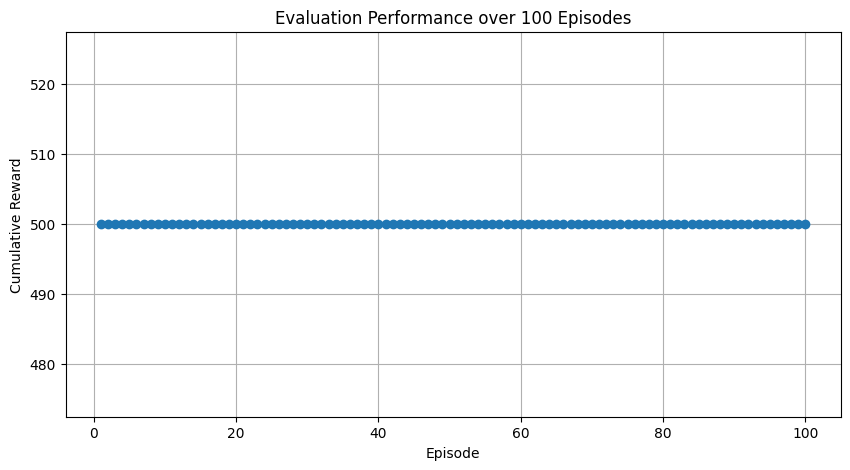

Average Reward over 100 evaluation episodes: 500.00


In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, eval_episode_to_record + 1), evaluation_rewards_for_DeepQ_Learning, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Evaluation Performance over 100 Episodes")
plt.grid(True)
plt.show()

# Also print the average reward
avg_reward = np.mean(evaluation_rewards_for_DeepQ_Learning)
print(f"Average Reward over {eval_episode_to_record} evaluation episodes: {avg_reward:.2f}")

### Evaluation of video

In [15]:
from IPython.display import Video
Video("./evaluation-episode-100.mp4", embed=True)

# Evaluation of Monte Carlo

### Import dependencies

In [26]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from abc import ABC, abstractmethod
from typing import NamedTuple
import pickle
from collections import defaultdict

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


In [35]:
env = gym.make("CartPole-v1")
env.reset()


array([-0.01150099,  0.03790724, -0.04231048, -0.01797239], dtype=float32)

In [36]:

print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


### define observation class and helper function: discretize state

In [37]:

class Observation(NamedTuple):
    cart_pos: int
    cart_vel: int
    pole_angle: int
    pole_vel: int

def discretize_state(observation):
  #
    cart_pos_bins = np.linspace(-4.8, 4.8, 10)
    cart_vel_bins = np.linspace(-5, 5, 10)
    pole_angle_bins = np.linspace(-0.418, 0.418, 10)
    pole_vel_bins = np.linspace(-5, 5, 10)

    return Observation(
        np.digitize(observation[0], cart_pos_bins),
        np.digitize(observation[1], cart_vel_bins),
        np.digitize(observation[2], pole_angle_bins),
        np.digitize(observation[3], pole_vel_bins)
    )

### Define MonteCarlo Agent

In [38]:
class MonteCarloAgent: # random default values for hyperparameters
    def __init__(self, action_space_size, load_from_file=True, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
      self.action_space_size = action_space_size
      self.alpha = alpha  # learning rate
      self.gamma = gamma  # discount factor
      self.epsilon = epsilon  # exploration %
      self.epsilon_min = epsilon_min
      self.epsilon_decay = epsilon_decay

      # use defaultdict to dynamically store Q-values
      self.Q = defaultdict(lambda: 10)  # high Q-values for optimism
      self.returns = defaultdict(list)
      self.N = defaultdict(int)
      self.filename = "mc_q_table.pkl"

      # load Q-table if available
      if load_from_file:
        self.load_q_table()

    def save_q_table(self):
      with open(self.filename, "wb") as file:
        pickle.dump((dict(self.Q), dict(self.returns), dict(self.N)), file)

    def load_q_table(self):
      try:
        with open(self.filename, "rb") as file:
          self.Q, self.returns, self.N = pickle.load(file)
          self.Q = defaultdict(int, self.Q)
          self.returns = defaultdict(list, self.returns)
          self.N = defaultdict(int, self.N)
      except (EOFError, FileNotFoundError):
        print("No saved Q-table found. starting fresh.")


    # decay epsilon over time to encourage exploitation over time
    def decay_epsilon(self):
      self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def reset_q_table(self):
      self.Q = defaultdict(lambda: 10)
      self.returns = defaultdict(list)
      self.N = defaultdict(int)
      self.save_q_table()

    def choose_action(self, state):
      # epsilon-greedy action selection
      if np.random.uniform(0, 1) < self.epsilon:
        return np.random.choice(self.action_space_size) # explore
      else:
        return np.argmax([self.Q[(state, a)] for a in range(self.action_space_size)]) # exploit

    # update_Q will be called at the end of each episode. it takes the entire episode's experience as input
    # and calculates the return G for each state-action pair throughout the episode and accumulating the
    # rewards. Q-value for each state-action pair is updated using the calculated return G
    def update_Q(self, episode):
      G = 0
      visited_state_action_pairs = set()

      for t in reversed(range(len(episode))):
        state, action, reward = episode[t]
        G = self.gamma * G + reward

        # first-visit Monte Carlo - compared to every-visit, often preferred due to its faster convergence
        if (state, action) not in visited_state_action_pairs:
          visited_state_action_pairs.add((state, action))
          self.returns[(state, action)].append(G)
          self.N[state, action] += 1

          # updating Q-value using the learning rate (alpha)
          self.Q[state, action] += self.alpha * (G - self.Q[state, action])

      self.save_q_table()  # save progress after every episode


### Run the evaluation and record the video:

In [39]:
eval_rewards = []
num_eval_episodes = 100
agent = MonteCarloAgent(env.action_space.n, alpha=0.05, gamma=0.99, epsilon=0.15)

for episode_num in range(num_eval_episodes):
    observation = env.reset()
    episode_reward = 0

    while not done:
      state = discretize_state(observation)
      action = agent.choose_action(state)
      observation, reward, done, info = env.step(action)
      episode_reward += reward

    eval_rewards.append(episode_reward)
    print(f"Evaluation Episode {episode_num + 1}: Reward = {episode_reward}")

Evaluation Episode 1: Reward = 0
Evaluation Episode 2: Reward = 0
Evaluation Episode 3: Reward = 0
Evaluation Episode 4: Reward = 0
Evaluation Episode 5: Reward = 0
Evaluation Episode 6: Reward = 0
Evaluation Episode 7: Reward = 0
Evaluation Episode 8: Reward = 0
Evaluation Episode 9: Reward = 0
Evaluation Episode 10: Reward = 0
Evaluation Episode 11: Reward = 0
Evaluation Episode 12: Reward = 0
Evaluation Episode 13: Reward = 0
Evaluation Episode 14: Reward = 0
Evaluation Episode 15: Reward = 0
Evaluation Episode 16: Reward = 0
Evaluation Episode 17: Reward = 0
Evaluation Episode 18: Reward = 0
Evaluation Episode 19: Reward = 0
Evaluation Episode 20: Reward = 0
Evaluation Episode 21: Reward = 0
Evaluation Episode 22: Reward = 0
Evaluation Episode 23: Reward = 0
Evaluation Episode 24: Reward = 0
Evaluation Episode 25: Reward = 0
Evaluation Episode 26: Reward = 0
Evaluation Episode 27: Reward = 0
Evaluation Episode 28: Reward = 0
Evaluation Episode 29: Reward = 0
Evaluation Episode 30: 

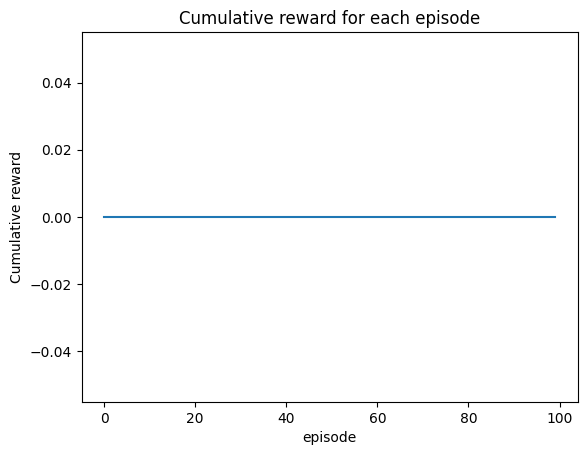

In [21]:
plt.plot(eval_rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()


In [22]:

mean = sum(eval_rewards) / len(eval_rewards)
print(mean)


0.0


In [23]:

print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 0.0
Is my agent good enough? False


### Evaluate the video

In [24]:

env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()

# Assuming you have already defined and trained your MonteCarloAgent (agent)
# and have state_space_size and action_space_size defined

# Initialize the agent here (if not already done)
agent = MonteCarloAgent(env.action_space.n, alpha=0.05, gamma=0.99, epsilon=0.15)

while True:
    env.render()

    # Get the current state and discretize it
    state = discretize_state(observation)

    # Choose an action using the agent's policy
    action = agent.choose_action(state)

    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

# Comparisons of graph

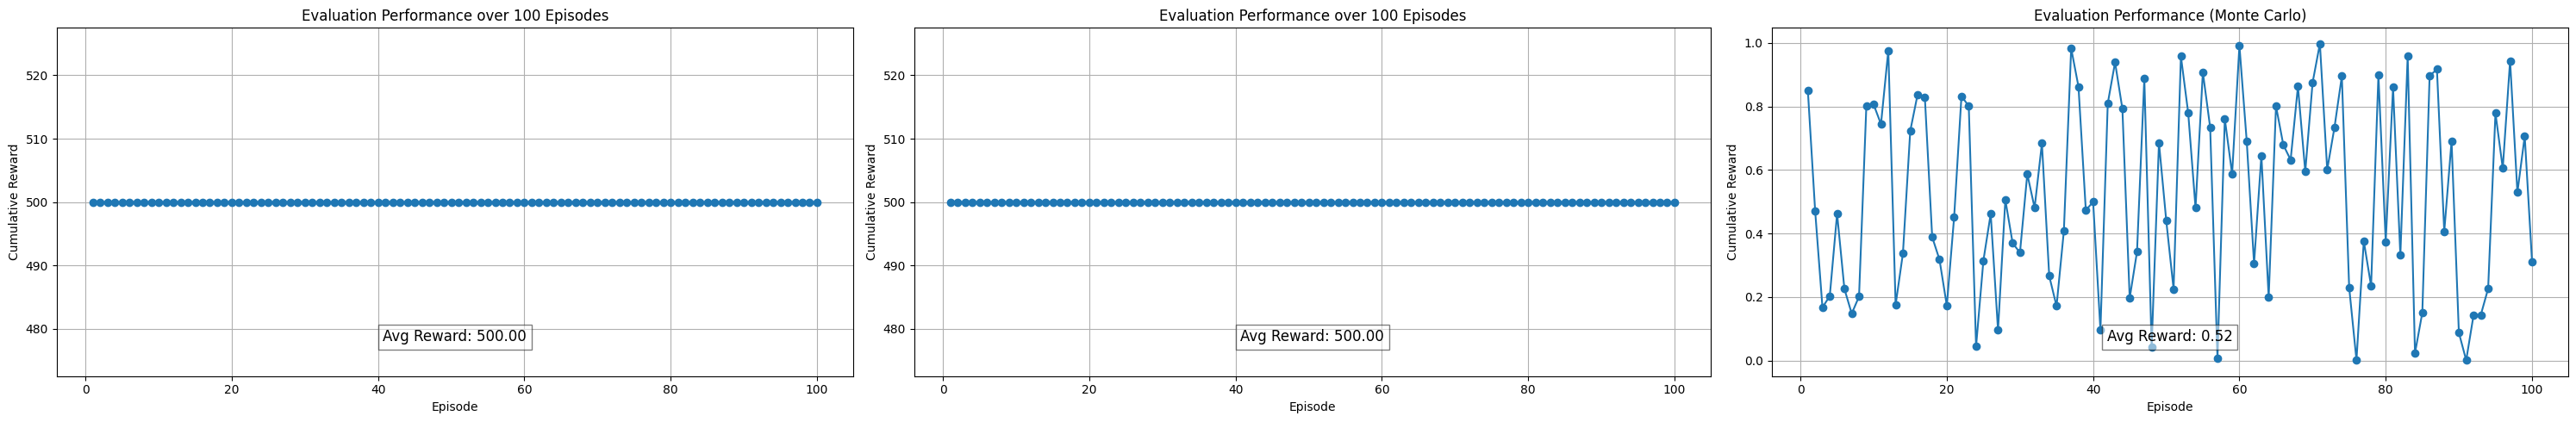

In [25]:
evaluation_rewards_for_monte_carlo = eval_rewards


import matplotlib.pyplot as plt
import numpy as np

# Example variables (replace these with your actual values)
eval_episode_to_record = 100
eval_episodes = 100

# Example reward data (replace these with your actual reward arrays)
evaluation_rewards = np.random.uniform(low=0, high=1, size=eval_episode_to_record)
evaluation_rewards_for_monte_carlo = np.random.uniform(low=0, high=1, size=eval_episode_to_record)

# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(30, 5))

# First subplot: using eval_episode_to_record
axes[0].plot(range(1, eval_episode_to_record + 1), evaluation_rewards_for_DeepQ_Learning, marker='o', linestyle='-')
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Cumulative Reward")
axes[0].set_title(f"Evaluation Performance over {eval_episode_to_record} Episodes")
axes[0].grid(True)
avg_reward1 = np.mean(evaluation_rewards_for_DeepQ_Learning)
axes[0].text(0.5, 0.1, f"Avg Reward: {avg_reward1:.2f}",
             transform=axes[0].transAxes, horizontalalignment='center',
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Second subplot: using eval_episodes
axes[1].plot(range(1, eval_episodes + 1), evaluation_rewards_Q_Learning, marker='o', linestyle='-')
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Cumulative Reward")
axes[1].set_title(f"Evaluation Performance over {eval_episodes} Episodes")
axes[1].grid(True)
avg_reward2 = np.mean(evaluation_rewards_Q_Learning)
axes[1].text(0.5, 0.1, f"Avg Reward: {avg_reward2:.2f}",
             transform=axes[1].transAxes, horizontalalignment='center',
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Third subplot: for evaluation_rewards_for_monte_carlo
axes[2].plot(range(1, len(evaluation_rewards_for_monte_carlo) + 1), evaluation_rewards_for_monte_carlo, marker='o', linestyle='-')
axes[2].set_xlabel("Episode")
axes[2].set_ylabel("Cumulative Reward")
axes[2].set_title("Evaluation Performance (Monte Carlo)")
axes[2].grid(True)
avg_reward3 = np.mean(evaluation_rewards_for_monte_carlo)
axes[2].text(0.5, 0.1, f"Avg Reward: {avg_reward3:.2f}",
             transform=axes[2].transAxes, horizontalalignment='center',
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

